In [2]:
from platform import python_version
print("Python version used for this analysis is:", python_version()) #Shows python version being used

Python version used for this analysis is: 3.12.4


In [3]:
import pandas as pd #imports pandas library as pd for dataframe manipulation 
import numpy as np #imports numpy as np for numeric calculations
import matplotlib.pyplot as plt #imports matplotlib.pyplot for visualzaions
from statsmodels.tsa.seasonal import seasonal_decompose #imports seasonal decompose for seasonal decompisition
from scipy import signal #importats signal for SDA
from datetime import datetime #imports datetime for time index
from statsmodels.tsa.stattools import adfuller #imports adfuller for ADF test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #imports plot acf & plot pacf for visualizing acf and pacf
from pandas.plotting import autocorrelation_plot #imports autocorrelationplot to visualize autocorrelation 
!pip install pmdarima #installs pmdarima for auto_arima
import pmdarima as pm  #installs pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX #imports SARIMAX for forecasting
import warnings
warnings.filterwarnings("ignore") #ignores warnings 
import joblib #imports joblib to save final model
%matplotlib inline 
#for visualzing matplotlib visualizations in notebook 

In [4]:
df = pd.read_csv('/Users/smzerbe/Documents/teleco_time_series .csv', dtype={'locationid': np.int64}) #loads dataset

In [5]:
print(df.shape) #shows rows and columns of dataset

(731, 2)


In [6]:
print(df.describe()) #shows summary stats of dataset

              Day     Revenue
count  731.000000  731.000000
mean   366.000000    9.822901
std    211.165812    3.852645
min      1.000000    0.000000
25%    183.500000    6.872836
50%    366.000000   10.785571
75%    548.500000   12.566911
max    731.000000   18.154769


In [7]:
print(df.head(10)) #prints first 10 rows of dataset

   Day   Revenue
0    1  0.000000
1    2  0.000793
2    3  0.825542
3    4  0.320332
4    5  1.082554
5    6  0.107654
6    7  0.493901
7    8  0.376698
8    9  0.304075
9   10  0.591748


In [8]:
print(df.isnull().any()) #shows if there are null values in any columns

Day        False
Revenue    False
dtype: bool


In [9]:
df['Date'] = pd.date_range(start=datetime(2019, 1, 1), periods=df.shape[0], freq='24H') #creates date column beginning 1/1/2019
df.set_index('Date', inplace=True) #sets date as index for time series analysis

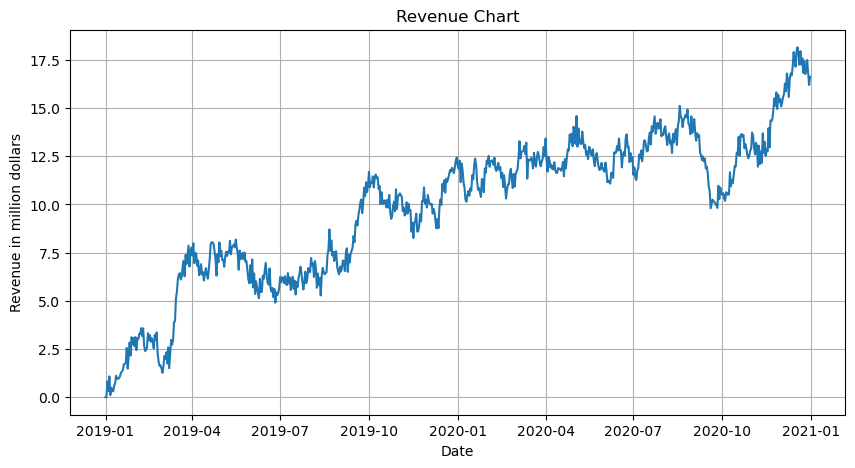

In [10]:
plt.figure(figsize=(10, 5)) #creates chart 
plt.plot(df.Revenue) #uses revenue for plot points
plt.title('Revenue Chart') #titles chart
plt.xlabel('Date') #makes x axis Date
plt.ylabel('Revenue in million dollars') #makes y axis Revenue in million dollars
plt.grid(True) #adds grid to chart
plt.show() #shows chart

In [11]:
result = adfuller(df['Revenue']) #Does ADF test on revenue to check for stationarity
print("Test statistics: ", result[0]) #Shows ADF test stats
print("p-value: ", result[1]) #shows p-value used for test
print("Critical values: ", result[4]) #shows critical values for 1%, 5%, & 10%
if result[1] <= 0.05:
    print("Reject null hypothesis, the time series is stationary") #if p-value is at or above 0.05 says to fail to reject null hypothesis
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")  #if p-value is below 0.05 says to reject null hypothesis

Test statistics:  -1.9246121573101873
p-value:  0.32057281507939484
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Fail to reject null hypothesis, the time series is non-stationary


In [12]:
df_stationary = df.diff().dropna() #makes new dataset that is stationary, then drops null values
df_stationary.head(5) #shows 1st 5 rows of stationary dataset

,Day,Revenue
Date,,
2019-01-02,1.0,0.000793
2019-01-03,1.0,0.824749
2019-01-04,1.0,-0.505210
2019-01-05,1.0,0.762222
2019-01-06,1.0,-0.974900


In [13]:
result = adfuller(df_stationary['Revenue']) #Does ADF test on stattionary revenue to check for stationarity
print("Test statistics: ", result[0])  #Shows ADF test stats
print("p-value: ", result[1]) #shows p-value used for test
print("Critical values: ", result[4]) #shows critical values for 1%, 5%, & 10%
if result[1] <= 0.05:
    print("Reject null hypothesis, the time series is stationary") #if p-value is at or above 0.05 says to fail to reject null hypothesis
else:
    print("Fail to reject null hypothesis, the time series is non-stationary") #if p-value is below 0.05 says to reject null hypothesis

Test statistics:  -44.874527193875984
p-value:  0.0
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


In [14]:
X_train = df_stationary.loc[:'2020-09-30'] #Creates training set with data up to Sept 30 2020
X_test = df_stationary.loc['2020-10-01':] #Createst testing set with data on and after Oct 1 2020
print("X_train Shape:", X_train.shape) #shows rows and columns of training data
print("X_test Shape:", X_test.shape) #shows rows and columns of testing data

X_train Shape: (638, 2)
X_test Shape: (92, 2)


In [15]:
df_stationary['Set'] = 'train' #adds set column to train data to identify what was in training set
df_stationary.loc['2020-10-01':, 'Set'] = 'test' #adds set column to test data to identify what was in testing set
df_stationary.to_csv('cleaned_teleco_time_series_split.csv', index=True) #saves cleaned dataset with training/testing set column

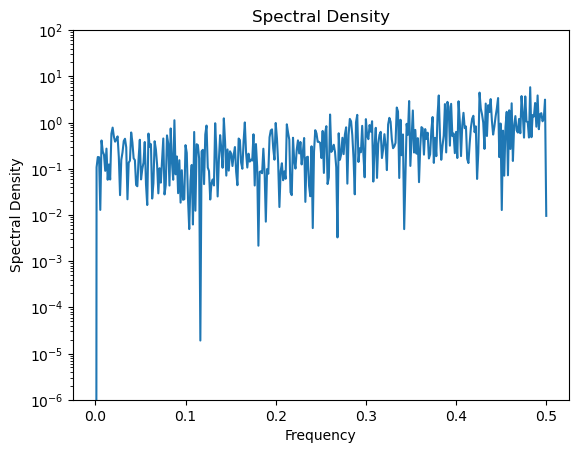

In [16]:
f, Pxx_den = signal.periodogram(df_stationary['Revenue']) #finds spectral density of stationary revenue 
plt.semilogy(f, Pxx_den) #plots spectral density on y axis 
plt.ylim([1e-6, 1e2]) #sets y axis limits 
plt.title('Spectral Density') #titles chart
plt.xlabel('Frequency') #titles x axis
plt.ylabel('Spectral Density') #titles y axis
plt.show() #shows chart

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

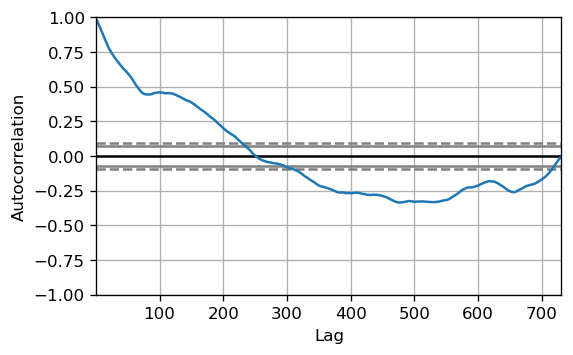

In [17]:
plt.rcParams.update({'figure.figsize': (5,3), 'figure.dpi': 120}) #sets plot size and resolution for charts 
autocorrelation_plot(df.Revenue.tolist()) #creates autocorrelation plot for seasonality patterns 

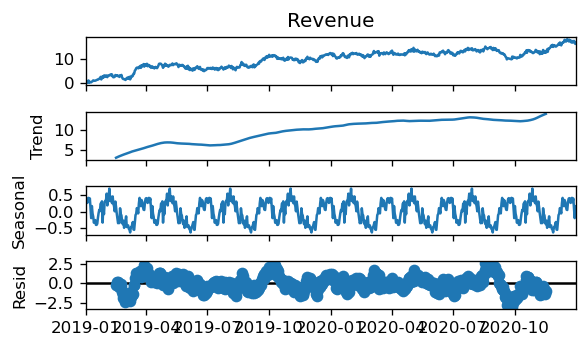

In [18]:
decomp = seasonal_decompose(df['Revenue'], period=90) #decomposes revenue data over quarterly period (90 days)
decomp.plot() #plots decomposed components 
plt.show() #shows charts (revenue, trend, seasonal, and residual) 

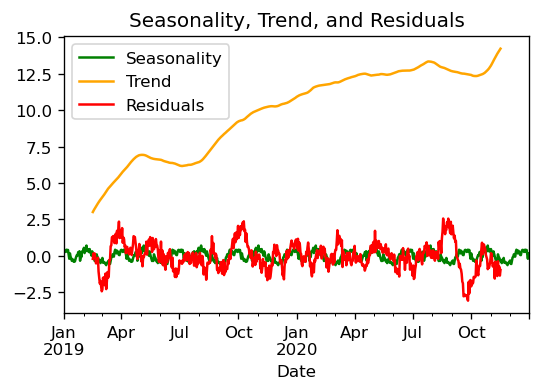

In [19]:
plt.title('Seasonality, Trend, and Residuals') #titles graph
decomp.seasonal.plot(label='Seasonality', color='green') #plots seasonal component of dataset
decomp.trend.plot(label='Trend', color='orange') #plots trend of dataset
decomp.resid.plot(label='Residuals', color='red') #plots residual of dataset
plt.legend() #makes legend

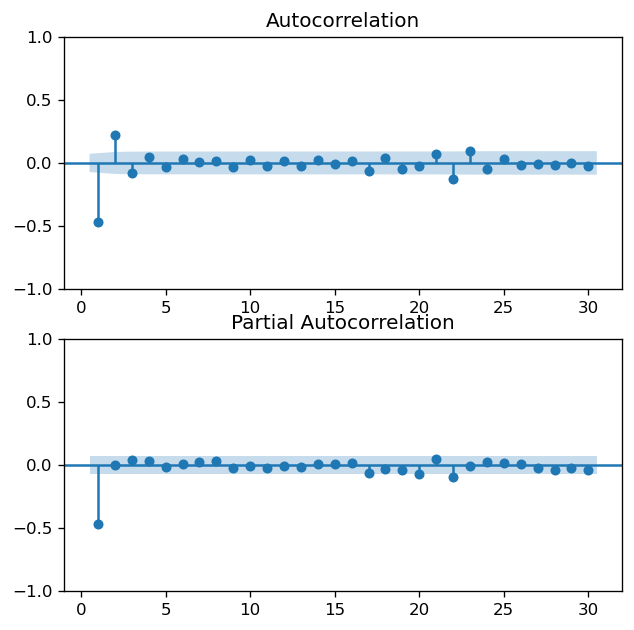

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6)) #makes subplot chart for acf and pacf (2 rows 1 column)
plot_acf(df_stationary['Revenue'], lags=30, zero=False, ax=ax1) #plots acf for stationary revenue with 30 lags
plot_pacf(df_stationary['Revenue'], lags=30, zero=False, ax=ax2) #plots pacf for stationary revenue with 30 lags
plt.show() #shows acf and pacf plots

In [21]:
best_aic = np.inf #makes best AIC infitnite 
best_order = None #defines best_order, will be replaced by p and q
rng = range(3) #makes range for p & q 0 ,1, and 2
for p in rng:
    for q in rng: #makes loop for p and q using range 3 (0,1,2)
        try:
            model = SARIMAX(df['Revenue'], order=(p, 1, q), trend='c') #makes SARIMAX model with 1 as parameter and contstant trend
            results = model.fit(disp=False) #defines results as fitted model
            tmp_aic = results.aic #stores AIC for intial model as tmp_aic 
            print(p, q, results.aic, results.bic) #prints p and q with their aic/bic values      
            if tmp_aic < best_aic: #if temporary model has best aic score make it best_aic/best_order
                best_aic = tmp_aic 
                best_order = (p, q)
        except: #if model fails print the p q combo that failed to fit 
            print(p, q, None, None)
print("\nBest AIC: {:6.5f} | Best order: {}".format(best_aic, best_order)) #shows the best model based on aic

0 0 1162.8186442465833 1172.0047333148682
0 1 1019.3694200274366 1033.148553629864
0 2 986.5461170213364 1004.9182951579062
1 0 983.1218204906913 996.9009540931187
1 1 985.1063519727292 1003.478530109299
1 2 985.6279606972871 1008.5931833679992
2 0 985.1037013602281 1003.4758794967979
2 1 986.0448017286144 1009.0100243993265
2 2 987.3046225205532 1014.8628897254077

Best AIC: 983.12182 | Best order: (1, 0)


In [ ]:
model = pm.auto_arima(df['Revenue'], #uses revenue SARIMAX model to run auto-arima to find best model based on aic
                      seasonal=True, #allows for seasonal testing
                      m=90, #makes seaonal 90 day periods 
                      d=1, D=1, #makes differencing order 1 for seasonal/nonseasonal
                      start_p=0, start_q=0, #starts p and q in nonseasonal period 
                      max_p=2, max_q=2, #limits range to 2 for seasonal/non seasonal
                      max_P=2, max_Q=2, #limits range to 2 for seasonal/non seasonal 
                      trace=True, #shows each model test as it goes along
                      error_action='ignore', #ignores errors for failed models 
                      suppress_warnings=True)
print(model.summary()) #prints stats for best model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[90]             : AIC=inf, Time=71.58 sec
 ARIMA(0,1,0)(0,1,0)[90]             : AIC=1433.753, Time=2.29 sec
 ARIMA(1,1,0)(1,1,0)[90]             : AIC=inf, Time=22.82 sec


In [ ]:
model = SARIMAX(df['Revenue'], #makes SARIMAX model using best non seasonal/seasonal ARIMA parameters
                order=(1, 1, 0), 
                seasonal_order=(0, 1, 0, 90))  
results = model.fit() #defines results as fitted model 
print(results.summary()) #shows summary of results 

In [ ]:
mae = np.mean(np.abs(results.resid)) #calculates mean absolute error
print("Mean absolute error:", mae) #shows mean absolute error 

In [ ]:
results.plot_diagnostics(figsize=(10, 8)) #makes diagnostic graphs based on model 
plt.show() #shows diagnostic graphs 

In [ ]:
prediction = results.get_prediction(start=-90) #makes predictions (forecasts) for last 90 days compared to testing split
mean_prediction = prediction.predicted_mean #gets mean values of predictions for the forecast values
confidence_intervals = prediction.conf_int() #gets confidence interval for predicted values
lower_limits = confidence_intervals.loc[:, 'lower Revenue'] #gets lower limit of confidence interval for each predicted plot point
upper_limits = confidence_intervals.loc[:, 'upper Revenue'] #gets upper limit of confidence interval for each predicted plot point
plt.figure(figsize=(12,4)) #creates graph 
plt.plot(df.index[-90:], df['Revenue'].tail(90), label='observed (test set)', color='blue') #plots actual revenue from last 90 day period
plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast') #plots predicted revenue for last 90 days
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink') #makes area between confidence intervals pink
plt.title('Forecast comparing with test data') #titles graph
plt.xlabel('Date') #titles x axis
plt.ylabel('Revenue (in Millions)') #titles y axis
plt.legend() #creates legend 
plt.show() #shows graph

In [ ]:
diff_forecast = results.get_forecast(steps=180) #makes forecast 180 days into the future 
mean_forecast = diff_forecast.predicted_mean #gets mean values of predictions for the forecast values
confidence_intervals = diff_forecast.conf_int() #gets confidence interval for predicted values
lower_limits = confidence_intervals.loc[:, 'lower Revenue'] #gets lower limit of confidence interval for each predicted plot point
upper_limits = confidence_intervals.loc[:, 'upper Revenue'] #gets upper limit of confidence interval for each predicted plot point
plt.plot(df['Revenue'].index, df['Revenue'], label='observed') #plots all observed revenue data
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast') #plots 180 day forecast 
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink') #makes area in forecast between confidence intervals pink
plt.title('Revenue with forecasted projections for 2021') #titles graph
plt.xlabel('Date') #titles x axis
plt.ylabel('Revenue (in Millions)') #titles y axis
plt.xticks(rotation=45) #rotates x labels 45 degrees for better fit
plt.legend() #creates legend 
plt.show() #shows graph 

In [ ]:
plt.title('Revenue projection for year 2021') #makes graph 
plt.xlabel('Date') #titles x axis
plt.ylabel('Revenue (in Millions)') #titles y axis
mean_forecast.plot() #plots the 180 day forecast

In [ ]:
joblib.dump(model, "TimeSeriesModel.pkl") #Saves final SARIMAX model 